In [24]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
# stored one repo up in my fork of Spykes
from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# base paths/names
sess_names = np.load('sess_names.npy')
sess_name = sess_names[3]

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'


# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)
fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis', sess_name)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=True)


### Separate spike times by trials

Create a list of list that is N trials long w/ spike info from cpoke to endstate for each trial. 

**TODO** turn into function

In [204]:
test_neuron = spks_dict['spk_times'][0]
test_neurovis = NeuroVis(test_neuron)

In [226]:
raster = test_neurovis.get_raster(event= 'aud1_on', binsize = 100, df = beh_df, plot = False)

In [277]:

# initialize
tr_times = np.zeros((len(beh_df),2))
tr_spk_L = []

# make counter bc idx is not continous
tr = 0

for idx, row in beh_df.iterrows():
    
    # grab start time 100 ms before c poke
    tr_start = row['c_poke'] - 0.001
    
    # create end time so delays have same length
    # NOTE: this is specific for analyzing delay period only
    if row['delay'] == 2:
        tr_end = tr_start + 5.5
    elif row['delay'] == 4:
        tr_end = tr_start + 7.7
    elif row['delay'] == 6:
        tr_end = tr_start + 9.9
    else:
        print('Trial delay is not 2, 4 or 6 seconds')
    
    # append start and end times
    tr_times[tr,:] = tr_start, tr_end
    tr+=1
    
    # grab spike time within trial window & append them
    tr_spk_L.append(test_neuron[np.logical_and(test_neuron >= tr_start, test_neuron <= tr_end)])
    

### Discretizing 

Take spk times x trials above, & given a bin size (1 ms) search in trial & binarize

In [308]:
# 1 ms bins & sample rate
binsize = 0.001

tr_spk_binary = []

for itrial, tr_spk in enumerate(tr_spk_L):
    
    tr_start = tr_times[itrial][0]
    tr_end = tr_times[itrial][1]
    halfbin = binsize / 2
    bincenters = np.arange(tr_start + halfbin, tr_end, binsize)
    
    NBINS = len(bincenters)
    spike_count = []
     
    for ibin in range(NBINS):
        spike_in_bin = np.sum(np.logical_and(tr_spk >= (bincenters[ibin] - halfbin), 
                                 tr_spk <= (bincenters[ibin] + halfbin)))
        
        spike_count.append(spike_in_bin)

    tr_spk_binary.append(spike_count)
        
        

In [293]:
def gaussian(x, mu, sigsq):
    return (1 / np.sqrt(2 * np.pi * sigsq)) * np.exp(-(x - mu)**2 / (2 * sigsq))

In [294]:
test = gaussian(2, 0, 1)

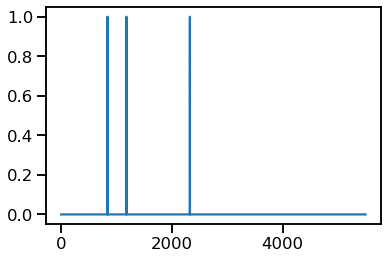

In [314]:
from scipy.ndimage import gaussian_filter

plt.plot(gaussian_filter(tr_spk_binary[0], sigma = .15))

In [50]:
# Initialize info for plotting
hit_df = beh_df[(beh_df['hit_hist'] == 'hit')]
aud1_df = hit_df[(hit_df['first_sound'] != 'psycho')]

## Stoped here

In [53]:
bndl_dfs, df_names = deal_with_masking(spks_dict, aud1_df, sess_path, 'aud1_no_psycho', 30000)

Loading existing mask_dict...
Done loading.
ngood, first: 175
ngood, first: 175
ngood, second: 195
ngood, second: 195


In [58]:
# initilaize
events = ['aud1_on']
event_names = ['aud1_on']
window = [-500, 2300]
condition = 'first_sound'

In [298]:
# initilaize
events = ['aud1_on']
windows = [[-1000,2300]]
condition = 'correct_side'

# get neurons into NeuroVis objects
neurons = initiate_neurons(spks_dict)
neuron = NeuroVis(spks_dict['spk_times'][0])

#single neuron debug
window = windows[0]
binsize = 100
df = bndl_dfs[df_names[0]]
phys_start = neuron.spiketimes[0]
phys_end = neuron.spiketimes[-1]
event = events[0]
conditions = 'correct_side'

In [13]:
neuron_rasters = get_neuron_rasters(neurons, events, windows, bndl_dfs, df_names)
neuron_psths = get_neuron_psths(neurons, events, windows, bndl_dfs, df_names, conditions=condition)

In [302]:
if not type(df) is dict:
        df = df.reset_index()
len(np.sum(raster['data'][0], axis = 1)), len(psth['data'][0]['mean'])

(14, 17)

In [176]:
if not type(df) is dict:
    df2 = df.reset_index()
wind = [np.floor(window[0]/binsize) * binsize, np.ceil(window[1]/binsize) * binsize]

In [177]:
trials = dict()
trials[0] = np.where(np.ones(np.size(df[event])))[0]
rasters = {
        'event': event,
        'conditions': conditions,
        'window': window,
        'binsize': binsize,
        'data': {},
    }

In [191]:
for cond_id in trials:
    # Select events relevant to this raster
    selected_events = df[event].iloc[trials[cond_id]]

    raster = []
    
    bin_template = 1e-3 * np.arange(window[0], window[1] + binsize, binsize)
    
    for event_time in selected_events:
        bins = event_time + bin_template



In [196]:
bin_template

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3])

In [195]:
for event_time in selected_events:
    bins = event_time + bin_template
    
    searchsorted_idx = np.sq

[5867.858354 5867.958354 5868.058354 5868.158354 5868.258354 5868.358354
 5868.458354 5868.558354 5868.658354 5868.758354 5868.858354 5868.958354
 5869.058354 5869.158354 5869.258354 5869.358354 5869.458354 5869.558354
 5869.658354 5869.758354 5869.858354 5869.958354 5870.058354 5870.158354
 5870.258354 5870.358354 5870.458354 5870.558354 5870.658354 5870.758354
 5870.858354 5870.958354 5871.058354 5871.158354]


In [212]:
event_time, event_time + 1e-3 * window[0], event_time + 1e-3 * window[1]

(5868.858354, 5867.858354, 5871.158354)